# Yue - optuna test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *


In [2]:
train_descriptors = pd.read_csv("train_descriptors.csv")
train_mord3d = pd.read_csv("train_mord3d.csv")
train_morgan = pd.read_csv("train_morgan.csv")
train_rdk = pd.read_csv("train_rdk.csv")

train_crystals = pd.read_csv("train_crystals.csv")
train_distances = pd.read_csv("train_distances.csv")
train_centroid_distances = pd.read_csv("train_centroid_distances.csv")

In [3]:
test_descriptors = pd.read_csv("test_descriptors.csv")
test_mord3d = pd.read_csv("test_mord3d.csv")
test_morgan = pd.read_csv("test_morgan.csv")
test_rdk = pd.read_csv("test_rdk.csv")

## Preprocessing

In [4]:
# Are there any redundant columns (all values the same)? These wouldn't contribute to the model at all

for col in train_descriptors.columns:
    if len(train_descriptors[col].unique()) == 1:

# If so, drop redundant columns:
        train_descriptors.drop(col,inplace=True,axis=1)

train_descriptors.shape # Drops to 1465 - ~150 redundant columns

(13449, 1465)

In [5]:
# Drop all columns with NA - Last 2 columns are InchiKey and SMILES

train_descriptors_full = train_descriptors.iloc[:, 3:-2].dropna(axis= 1, how="any")
train_descriptors_full.shape # previously (13449, 891)

(13449, 891)

In [6]:
test_descriptors_full = test_descriptors[train_descriptors_full.columns]
test_descriptors_full.shape

(3363, 891)

In [7]:
train_PCA = decomposition.PCA(n_components=.95)
scaler_for_PCA = preprocessing.StandardScaler()
train_descriptors_PCA = train_PCA.fit_transform(scaler_for_PCA.fit_transform(train_descriptors_full))
test_descriptors_PCA = train_PCA.transform(scaler_for_PCA.transform(test_descriptors_full))
print(train_descriptors_PCA.shape, test_descriptors_PCA.shape)

(13449, 124) (3363, 124)


In [9]:
# Split data into training and test sets
target = "calculated_density"
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_descriptors_PCA, train_crystals[target], random_state = 0)
print(len(X_train), len(X_valid))

10086 3363


## Simple hyperparameter tuning using optuna

Optuna is a optimization library that can be easily used for sklearn hyperparameters.

Most code based on this site: https://www.analyticsvidhya.com/blog/2020/11/hyperparameter-tuning-using-optuna/

You define an objective function which runs a model and returns a value to be minimized.  
Here, `objective()` is the function and it minimizes on the cross validation score.  
The random forest model has 2 main parameters - number of trees (`n_estimators`) and tree depth (`max_depth`)



In [15]:
import optuna

# set n_jobs = -1 when running models to use all processors

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    clf = ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
    return model_selection.cross_val_score(clf, X_train, y_train, 
                                           n_jobs=-1, scoring="neg_mean_absolute_error", cv=3).mean()

Once the objective function is created, optuna optimizes within 'studies':

In [16]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-08-12 10:28:10,744] A new study created in memory with name: no-name-8b0d9a6f-52d4-4071-a6b9-fad7e503d994
[I 2021-08-12 10:28:19,084] Trial 0 finished with value: -0.13118472607997464 and parameters: {'n_estimators': 170, 'max_depth': 3.5174491980808376}. Best is trial 0 with value: -0.13118472607997464.
[I 2021-08-12 10:28:39,438] Trial 1 finished with value: -0.06325575097796378 and parameters: {'n_estimators': 155, 'max_depth': 12.933442358650487}. Best is trial 1 with value: -0.06325575097796378.
[I 2021-08-12 10:28:43,926] Trial 2 finished with value: -0.15939783425454576 and parameters: {'n_estimators': 119, 'max_depth': 2.734731569780339}. Best is trial 1 with value: -0.06325575097796378.
[I 2021-08-12 10:28:56,512] Trial 3 finished with value: -0.06477716952424113 and parameters: {'n_estimators': 98, 'max_depth': 11.328574319047933}. Best is trial 1 with value: -0.06325575097796378.
[I 2021-08-12 10:29:15,138] Trial 4 finished with value: -0.0733731463015313 and paramet

Wall time: 34min 27s


Can use direct visualization (install plotly library) or write figures to image. Note: Also need to install [kaleido](https://github.com/optuna/optuna/issues/602) to export plotly figures


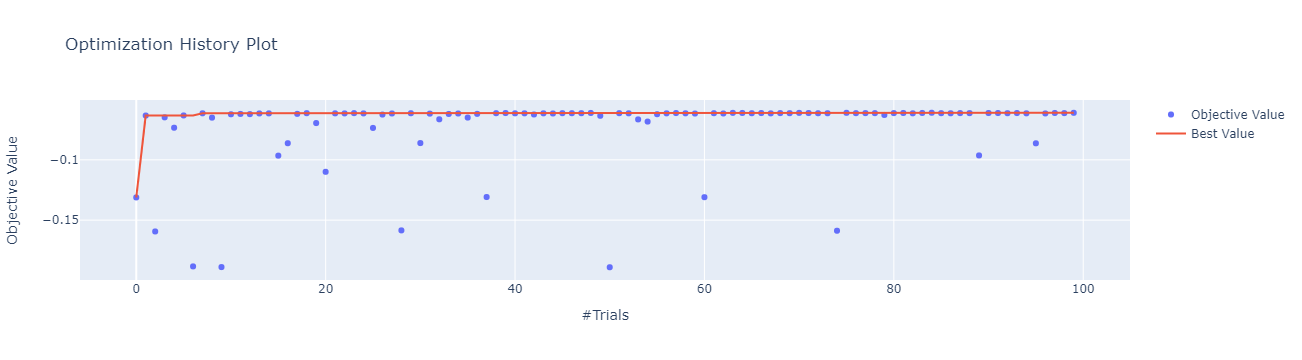

In [22]:
optuna.visualization.plot_optimization_history(study)

# Uncomment to write figure
# fig1 = optuna.visualization.plot_optimization_history(study)
# fig1.write_image('optuna_optimization_history.png')

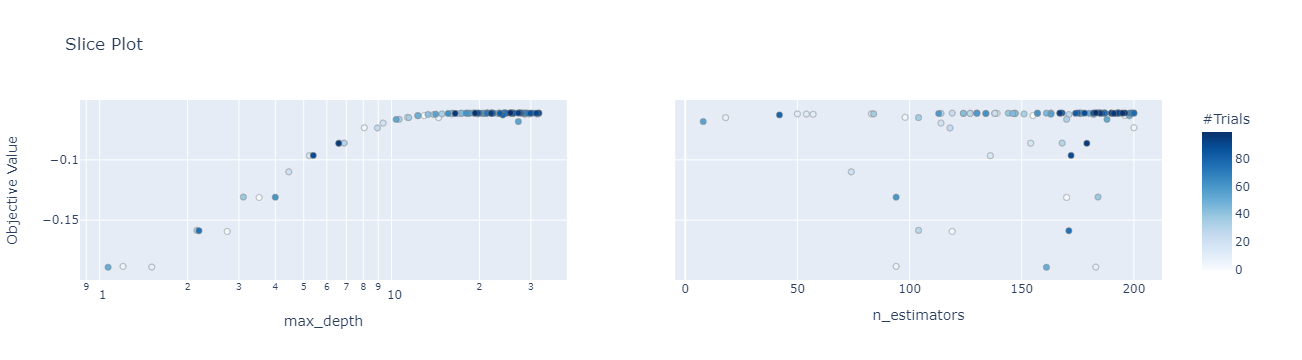

In [23]:
optuna.visualization.plot_slice(study)

# Uncomment to write figure
# fig2 = optuna.visualization.plot_slice(study)
# fig2.write_image('optuna_slice_plot.png')

Information about the trails can be extracted from the study:

In [20]:
trial = study.best_trial
trial

FrozenTrial(number=84, values=[-0.06095295831955927], datetime_start=datetime.datetime(2021, 8, 12, 10, 55, 33, 335544), datetime_complete=datetime.datetime(2021, 8, 12, 10, 56, 1, 720384), params={'n_estimators': 185, 'max_depth': 27.45628880326542}, distributions={'n_estimators': IntUniformDistribution(high=200, low=2, step=1), 'max_depth': LogUniformDistribution(high=32.0, low=1.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=84, state=TrialState.COMPLETE, value=None)

In [21]:
trial.values

[-0.06095295831955927]